In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [4]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 256  # Increased size for better performance
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {0: 'Not Tumor', 1: 'Necrotic/Core', 2: 'Edema', 3: 'Enhancing'}

# Rest of the data loading and splitting code remains the same

In [6]:
# List all case IDs and exclude cases with missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [case_id for case_id in all_ids if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))]

In [7]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(valid_ids, test_size=0.2, random_state=42)

In [9]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, dataset_path, batch_size=2, dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels  # 3 channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) * VOLUME_SLICES / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[int(k / VOLUME_SLICES)] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs) * VOLUME_SLICES)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.dim), dtype=np.uint8)

        for i, case_id in enumerate(Batch_ids):
            # Load image and segmentation data
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue

            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # Randomly select a slice
            j = np.random.randint(VOLUME_START_AT, VOLUME_START_AT + VOLUME_SLICES)

            # Resize images
            flair_slice = cv2.resize(flair[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)
            t1ce_slice = cv2.resize(t1ce[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)

            # Normalize each slice
            flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice) + 1e-8)
            t1ce_slice = (t1ce_slice - np.min(t1ce_slice)) / (np.max(t1ce_slice) - np.min(t1ce_slice) + 1e-8)

            # Stack channels
            X[i, :, :, 0] = flair_slice
            X[i, :, :, 1] = t1ce_slice
            X[i, :, :, 2] = 0.0  # Third channel as zeros

            # Process segmentation mask
            seg_slice = seg[:, :, j]
            seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)

            # Map label 4 to 3
            seg_resized[seg_resized == 4] = 3
            seg_resized = seg_resized.astype(np.uint8)

            y[i] = seg_resized

        # One-hot encode segmentation masks
        y_one_hot = tf.one_hot(y, depth=len(SEGMENT_CLASSES), axis=-1)

        return X, y_one_hot


In [10]:
# Initialize data generators for training and validation
training_generator = DataGenerator(train_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=True)
validation_generator = DataGenerator(val_ids, TRAIN_DATASET_PATH, batch_size=1, shuffle=False)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

In [15]:
def ASPP(inputs, filters):
    # Image Pooling branch
    y_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    y_pool = tf.keras.layers.Reshape((1, 1, -1))(y_pool)
    y_pool = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(y_pool)
    y_pool = tf.keras.layers.BatchNormalization()(y_pool)
    y_pool = tf.keras.layers.ReLU()(y_pool)

    # Now upsample to match the size of inputs using the custom layer
    y_pool = BilinearUpsampling()([y_pool, inputs])
    
    # 1x1 Conv branch
    y_1 = tf.keras.layers.Conv2D(filters, 1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = tf.keras.layers.BatchNormalization()(y_1)
    y_1 = tf.keras.layers.ReLU()(y_1)
    
    # 3x3 Conv branches with different dilation rates
    y_6 = tf.keras.layers.Conv2D(filters, 3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = tf.keras.layers.BatchNormalization()(y_6)
    y_6 = tf.keras.layers.ReLU()(y_6)
    
    y_12 = tf.keras.layers.Conv2D(filters, 3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = tf.keras.layers.BatchNormalization()(y_12)
    y_12 = tf.keras.layers.ReLU()(y_12)
    
    y_18 = tf.keras.layers.Conv2D(filters, 3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = tf.keras.layers.BatchNormalization()(y_18)
    y_18 = tf.keras.layers.ReLU()(y_18)
    
    # Concatenate all the branches
    y = tf.keras.layers.Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    
    # Output projection
    y = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    
    return y

In [17]:
def DeepLabV3Plus(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(SEGMENT_CLASSES)):
    # Input Layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder (Backbone)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Extract features at different levels
    x = base_model.get_layer('block6a_expand_activation').output  # Last feature map before upsampling
    low_level_features = base_model.get_layer('block3a_expand_activation').output  # Low-level features for decoder
    
    # Atrous Spatial Pyramid Pooling
    x = ASPP(x, filters=256)
    
    # Decoder
    # Upsample x to match low-level features
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    
    # Process low-level features
    low_level_features = tf.keras.layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_features)
    low_level_features = tf.keras.layers.BatchNormalization()(low_level_features)
    low_level_features = tf.keras.layers.ReLU()(low_level_features)
    
    # Concatenate
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    
    # Further processing
    x = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Final upsampling
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
import tensorflow as tf

def dice_loss_with_class_weights(y_true, y_pred, class_weights):
    # Flatten the tensors to calculate per-class Dice coefficient
    y_true_f = tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)])
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])
    
    # Calculate intersection and union per class
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    
    # Calculate Dice coefficient per class
    dice_coeff = (2. * intersection + 1e-6) / (union + 1e-6)
    
    # Calculate Dice loss per class
    dice_loss = 1 - dice_coeff
    
    # Apply class weights
    weighted_dice_loss = dice_loss * class_weights
    
    # Calculate mean loss
    mean_loss = tf.reduce_mean(weighted_dice_loss)
    
    return mean_loss

In [22]:
class CustomDiceLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, name='dice_loss'):
        super(CustomDiceLoss, self).__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def call(self, y_true, y_pred):
        return dice_loss_with_class_weights(y_true, y_pred, self.class_weights)

In [24]:
import numpy as np

In [26]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and labels to integer format
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super(CustomMeanIoU, self).update_state(y_true, y_pred, sample_weight)

In [32]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Define constants
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
IMG_SIZE = 256  # Adjusted image size for better performance
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {
    0: 'Not Tumor',
    1: 'Necrotic/Core',
    2: 'Edema',
    3: 'Enhancing'
}

# List all case IDs and exclude missing files
all_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
valid_ids = [
    case_id for case_id in all_ids
    if os.path.exists(os.path.join(TRAIN_DATASET_PATH, case_id, f"{case_id}_seg.nii"))
]

# Split the dataset
train_ids, val_ids = train_test_split(
    valid_ids, test_size=0.2, random_state=42
)

# Adjusted DataGenerator class
class DataGenerator(Sequence):
    def __init__(
        self, list_IDs, dataset_path, batch_size=4, slices_per_patient=5,
        dim=(IMG_SIZE, IMG_SIZE), n_channels=3, shuffle=True
    ):
        self.list_IDs = list_IDs
        self.dataset_path = dataset_path
        self.batch_size = batch_size  # Number of patients per batch
        self.slices_per_patient = slices_per_patient  # Number of slices per patient
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        Batch_ids = self.list_IDs[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.list_IDs)

    def __data_generation(self, Batch_ids):
        total_slices = len(Batch_ids) * self.slices_per_patient
        X = np.zeros((total_slices, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((total_slices, *self.dim), dtype=np.uint8)
        # Rest of the code remains the same

        
        count = 0
        for case_id in Batch_ids:
            # Load image and segmentation data
            flair_path = os.path.join(self.dataset_path, case_id, f"{case_id}_flair.nii")
            t1ce_path = os.path.join(self.dataset_path, case_id, f"{case_id}_t1ce.nii")
            seg_path = os.path.join(self.dataset_path, case_id, f"{case_id}_seg.nii")

            if not os.path.exists(seg_path):
                print(f"Skipping missing file: {seg_path}")
                continue

            # Load data
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for _ in range(self.slices_per_patient):
                # Randomly select a slice
                j = np.random.randint(VOLUME_START_AT, VOLUME_START_AT + VOLUME_SLICES)
                
                # Process image slices
                flair_slice = cv2.resize(flair[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)
                t1ce_slice = cv2.resize(t1ce[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)
                
                # Normalize slices
                flair_slice = (flair_slice - np.min(flair_slice)) / (np.max(flair_slice) - np.min(flair_slice) + 1e-8)
                t1ce_slice = (t1ce_slice - np.min(t1ce_slice)) / (np.max(t1ce_slice) - np.min(t1ce_slice) + 1e-8)
                
                # Stack channels
                X[count, :, :, 0] = flair_slice
                X[count, :, :, 1] = t1ce_slice
                X[count, :, :, 2] = 0.0  # Third channel as zeros
                
                # Process segmentation mask
                seg_slice = seg[:, :, j]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)
                
                # Map label 4 to 3
                seg_resized[seg_resized == 4] = 3
                seg_resized = seg_resized.astype(np.uint8)
                
                y[count] = seg_resized
                count += 1

        # One-hot encode segmentation masks
        y_one_hot = tf.one_hot(y, depth=len(SEGMENT_CLASSES), axis=-1)

        return X, y_one_hot

# Define custom Mean IoU metric
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and labels to integer format
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super(CustomMeanIoU, self).update_state(
            y_true, y_pred, sample_weight
        )

# Define the BilinearUpsampling layer
class BilinearUpsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BilinearUpsampling, self).__init__(**kwargs)

    def call(self, inputs):
        x, target = inputs
        # Get the dynamic shape of the target tensor
        target_shape = tf.shape(target)
        # Extract the height and width
        height = target_shape[1]
        width = target_shape[2]
        # Resize x to match the target size
        return tf.image.resize(
            x, size=(height, width), method='bilinear'
        )

# Implement ASPP function
def ASPP(inputs, filters):
    # Image Pooling branch
    y_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    y_pool = tf.keras.layers.Reshape((1, 1, -1))(y_pool)
    y_pool = tf.keras.layers.Conv2D(
        filters, 1, padding='same', use_bias=False
    )(y_pool)
    y_pool = tf.keras.layers.BatchNormalization()(y_pool)
    y_pool = tf.keras.layers.ReLU()(y_pool)

    # Now upsample to match the size of inputs using the custom layer
    y_pool = BilinearUpsampling()([y_pool, inputs])

    # 1x1 Conv branch
    y_1 = tf.keras.layers.Conv2D(
        filters, 1, dilation_rate=1, padding='same', use_bias=False
    )(inputs)
    y_1 = tf.keras.layers.BatchNormalization()(y_1)
    y_1 = tf.keras.layers.ReLU()(y_1)

    # 3x3 Conv branches with different dilation rates
    y_6 = tf.keras.layers.Conv2D(
        filters, 3, dilation_rate=6, padding='same', use_bias=False
    )(inputs)
    y_6 = tf.keras.layers.BatchNormalization()(y_6)
    y_6 = tf.keras.layers.ReLU()(y_6)

    y_12 = tf.keras.layers.Conv2D(
        filters, 3, dilation_rate=12, padding='same', use_bias=False
    )(inputs)
    y_12 = tf.keras.layers.BatchNormalization()(y_12)
    y_12 = tf.keras.layers.ReLU()(y_12)

    y_18 = tf.keras.layers.Conv2D(
        filters, 3, dilation_rate=18, padding='same', use_bias=False
    )(inputs)
    y_18 = tf.keras.layers.BatchNormalization()(y_18)
    y_18 = tf.keras.layers.ReLU()(y_18)

    # Concatenate all the branches
    y = tf.keras.layers.Concatenate()(
        [y_pool, y_1, y_6, y_12, y_18]
    )

    # Output projection
    y = tf.keras.layers.Conv2D(
        filters, 1, padding='same', use_bias=False
    )(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    return y

# Implement DeepLabV3+ model
def DeepLabV3Plus(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=len(SEGMENT_CLASSES)
):
    # Input Layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder (Backbone)
    base_model = EfficientNetB0(
        weights='imagenet', include_top=False, input_tensor=inputs
    )

    # Extract features at different levels
    x = base_model.get_layer(
        'block6a_expand_activation'
    ).output  # Last feature map before upsampling
    low_level_features = base_model.get_layer(
        'block3a_expand_activation'
    ).output  # Low-level features for decoder

    # Atrous Spatial Pyramid Pooling
    x = ASPP(x, filters=256)

    # Decoder
    # Upsample x to match low-level features
    x = tf.keras.layers.UpSampling2D(
        size=(4, 4), interpolation='bilinear'
    )(x)

    # Process low-level features
    low_level_features = tf.keras.layers.Conv2D(
        48, 1, padding='same', use_bias=False
    )(low_level_features)
    low_level_features = tf.keras.layers.BatchNormalization()(
        low_level_features
    )
    low_level_features = tf.keras.layers.ReLU()(low_level_features)

    # Concatenate
    x = tf.keras.layers.Concatenate()([x, low_level_features])

    # Further processing
    x = tf.keras.layers.Conv2D(
        256, 3, padding='same', use_bias=False
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(
        256, 3, padding='same', use_bias=False
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Final upsampling
    x = tf.keras.layers.UpSampling2D(
        size=(4, 4), interpolation='bilinear'
    )(x)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(
        num_classes, 1, activation='softmax'
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate the model
model = DeepLabV3Plus(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=len(SEGMENT_CLASSES)
)

# Define the custom Dice Loss
def dice_loss_with_class_weights(y_true, y_pred, class_weights):
    # Flatten the tensors to calculate per-class Dice coefficient
    y_true_f = tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)])
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])

    # Calculate intersection and union per class
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)

    # Calculate Dice coefficient per class
    dice_coeff = (2. * intersection + 1e-6) / (union + 1e-6)

    # Calculate Dice loss per class
    dice_loss = 1 - dice_coeff

    # Apply class weights
    weighted_dice_loss = dice_loss * class_weights

    # Calculate mean loss
    mean_loss = tf.reduce_mean(weighted_dice_loss)

    return mean_loss

class CustomDiceLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, name='dice_loss'):
        super(CustomDiceLoss, self).__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)

    def call(self, y_true, y_pred):
        return dice_loss_with_class_weights(
            y_true, y_pred, self.class_weights
        )

# Define loss and metrics
class_weights = np.array([0.1, 0.3, 0.3, 0.3])
dice_loss = CustomDiceLoss(class_weights=class_weights)
custom_mean_iou = CustomMeanIoU(num_classes=len(SEGMENT_CLASSES))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', custom_mean_iou]
)

# Initialize data generators
training_generator = DataGenerator(
    train_ids,
    TRAIN_DATASET_PATH,
    batch_size=4,
    slices_per_patient=5,
    shuffle=True
)
validation_generator = DataGenerator(
    val_ids,
    TRAIN_DATASET_PATH,
    batch_size=4,
    slices_per_patient=5,
    shuffle=False
)

# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
    ),
    CSVLogger(
        'deeplabv3plus_training.log', separator=',', append=False
    )
]

# Calculate steps per epoch
steps_per_epoch = len(training_generator)
validation_steps = len(validation_generator)

# Train the model
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

# Save the model
model.save("brain_tumor_segmentation_deeplabv3plus.h5")

Epoch 1/35
41/74 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.6722 - custom_mean_io_u_2: 0.1921 - loss: 0.1998

2024-11-15 12:58:27.120376: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,304,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,304,64,64]{3,2,1,0}, f32[10,256,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-15 12:58:27.215388: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.095139618s
Trying algorithm eng0{} for conv (f32[256,304,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,304,64,64]{3,2,1,0}, f32[10,256,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

74/74 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7013 - custom_mean_io_u_2: 0.1956 - loss: 0.1871 - val_accuracy: 0.6801 - val_custom_mean_io_u_2: 0.1786 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 2/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 444ms/step - accuracy: 0.8076 - custom_mean_io_u_2: 0.3780 - loss: 0.1452 - val_accuracy: 0.9844 - val_custom_mean_io_u_2: 0.2445 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 3/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 448ms/step - accuracy: 0.9155 - custom_mean_io_u_2: 0.4429 - loss: 0.1270 - val_accuracy: 0.9853 - val_custom_mean_io_u_2: 0.2448 - val_loss: 0.2252 - learning_rate: 0.0010
Epoch 4/35
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9920 - custom_mean_io_u_2: 0.6008 - loss: 0.0894
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.9920 - custom_mean_io_u_2: 0.6010 - loss: 0.0893 - val_accuracy: 0.9837 - val_custom_mean_io_u_2: 0.2443 - val_loss: 0.2

In [31]:
print(f"Training steps per epoch: {len(training_generator)}")
print(f"Validation steps per epoch: {len(validation_generator)}")

Training steps per epoch: 73
Validation steps per epoch: 18


In [33]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_mean_iou = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Mean IoU: {val_mean_iou:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.9952 - custom_mean_io_u_2: 0.6945 - loss: 0.0626
Validation Loss: 0.0654
Validation Accuracy: 0.9945
Validation Mean IoU: 0.6907


In [34]:
def compute_dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1, len(SEGMENT_CLASSES)])
    y_pred_f = tf.reshape(y_pred, [-1, len(SEGMENT_CLASSES)])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_coeff = (2. * intersection + 1e-6) / (union + 1e-6)
    return dice_coeff.numpy()

# Get predictions on the validation set
y_true_list = []
y_pred_list = []

for X_batch, y_batch in validation_generator:
    y_pred_batch = model.predict(X_batch)
    y_true_list.append(y_batch)
    y_pred_list.append(y_pred_batch)

    # Stop after one full pass
    if len(y_true_list) >= len(validation_generator):
        break

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Compute Dice coefficient
dice_coeff = compute_dice_coefficient(y_true, y_pred)
print("Dice Coefficient per class:")
for i, class_name in SEGMENT_CLASSES.items():
    print(f"Class {i} ({class_name}): {dice_coeff[i]:.4f}")
print(f"Mean Dice Coefficient: {np.mean(dice_coeff):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Dice Coefficient per class:
Class 0 (Not Tumor): 0.9981
Class 1 (Necrotic/Core): 0.6919
Class 2 (Edema): 0.7651
Class 3 (Enhancing): 0.7590
Mean Dice Coefficient: 0.8035


In [38]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_generator, num_images=5):
    # Set the color map for segmentation classes
    cmap = plt.get_cmap('jet', len(SEGMENT_CLASSES))

    for X_batch, y_true_batch in data_generator:
        y_pred_batch = model.predict(X_batch)
        y_pred_argmax = np.argmax(y_pred_batch, axis=-1)
        y_true_argmax = np.argmax(y_true_batch, axis=-1)

        for i in range(num_images):
            plt.figure(figsize=(15, 5))

            # Original Image (FLAIR)
            plt.subplot(1, 3, 1)
            plt.imshow(X_batch[i, :, :, 0], cmap='gray')
            plt.title('Input Image (FLAIR)')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(y_true_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Ground Truth Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Predicted Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        # Break after visualizing the desired number of images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


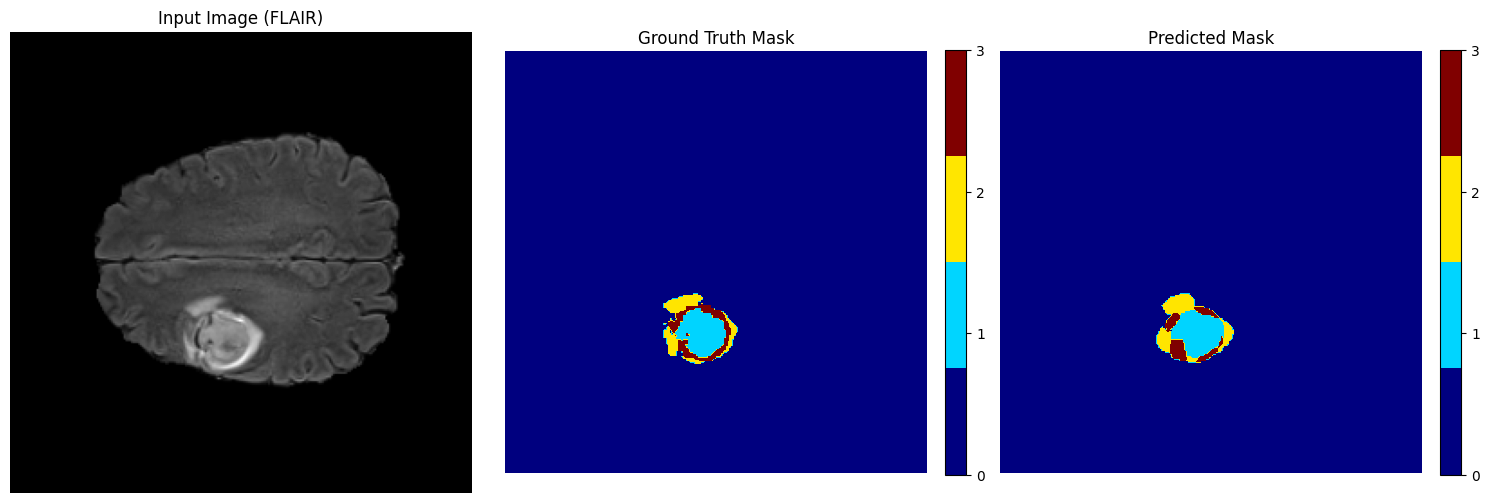

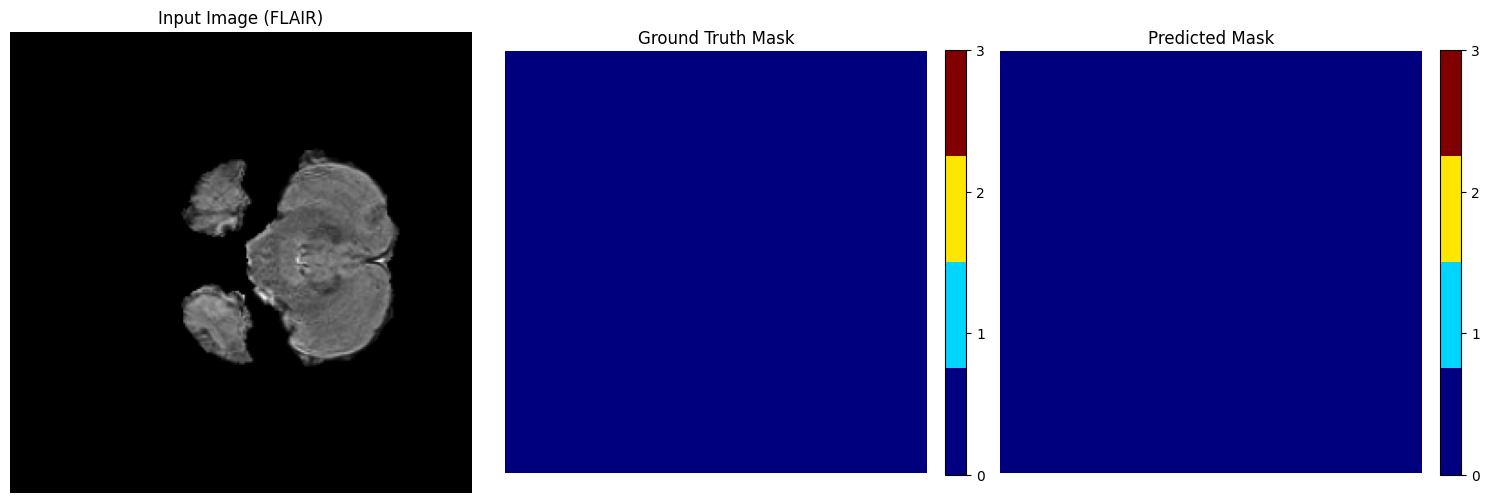

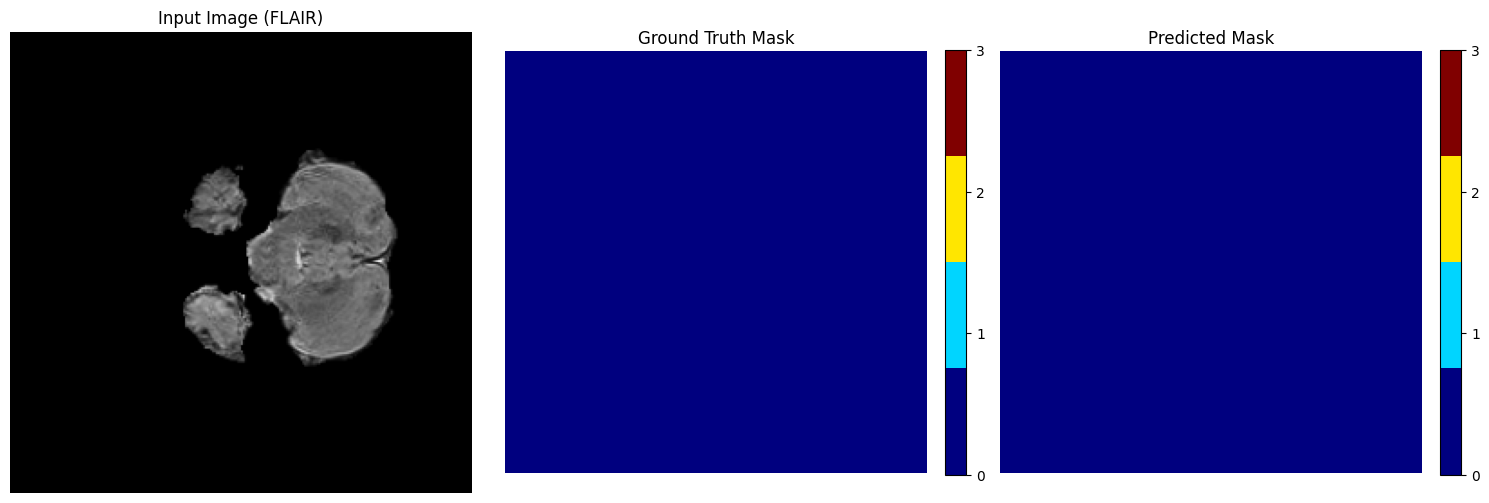

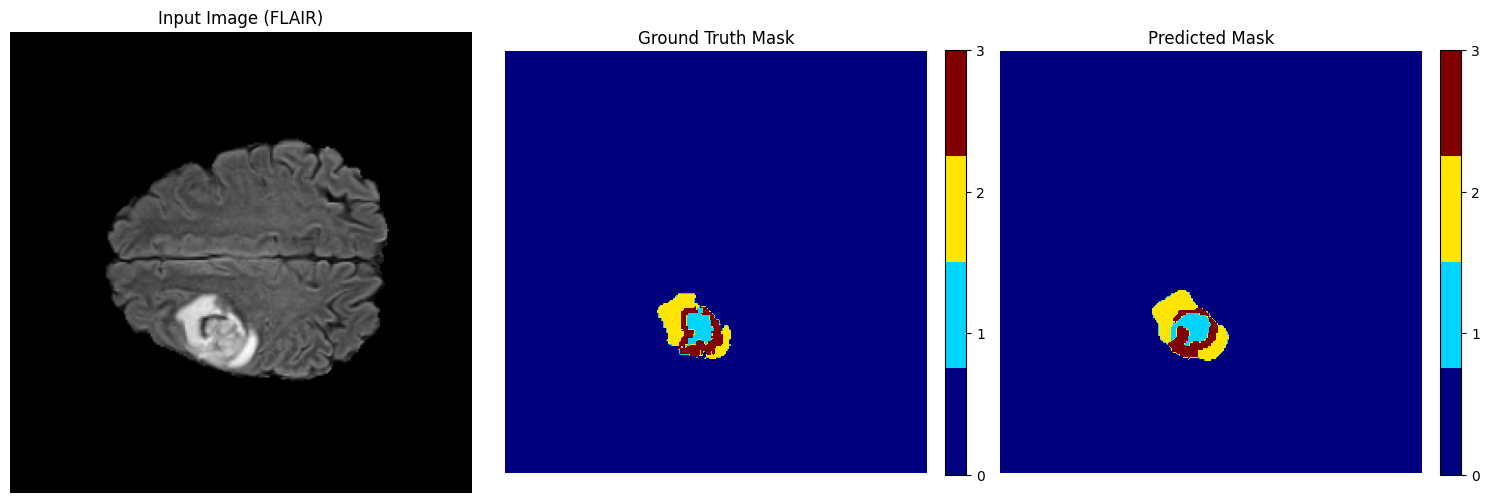

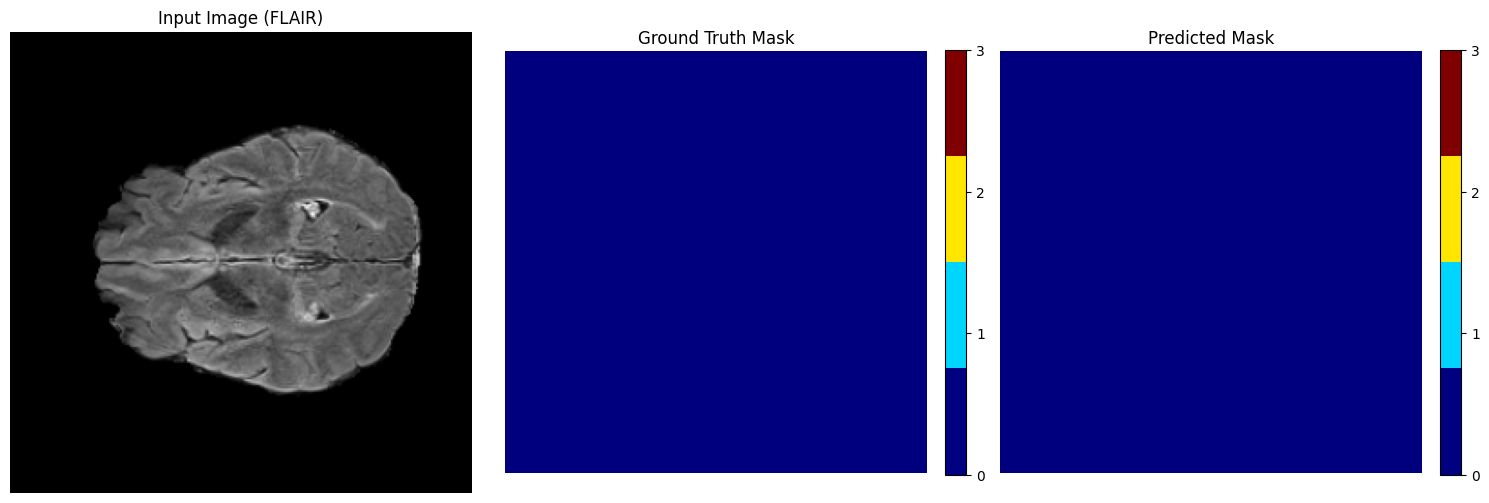

In [39]:
# Visualize predictions on the validation set
visualize_predictions(model, validation_generator, num_images=5)

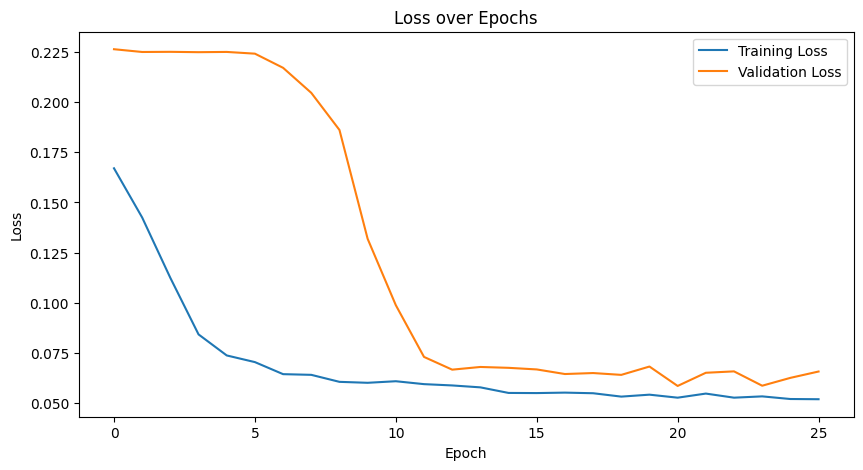

KeyError: 'custom_mean_io_u'

<Figure size 1000x500 with 0 Axes>

In [42]:
import os
import matplotlib.pyplot as plt

# Create 'images' directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/loss_plot.png')
plt.show()

# Plot Training and Validation Mean IoU
plt.figure(figsize=(10, 5))
plt.plot(history.history['custom_mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_custom_mean_io_u'], label='Validation Mean IoU')
plt.title('Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.savefig('images/mean_iou_plot.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


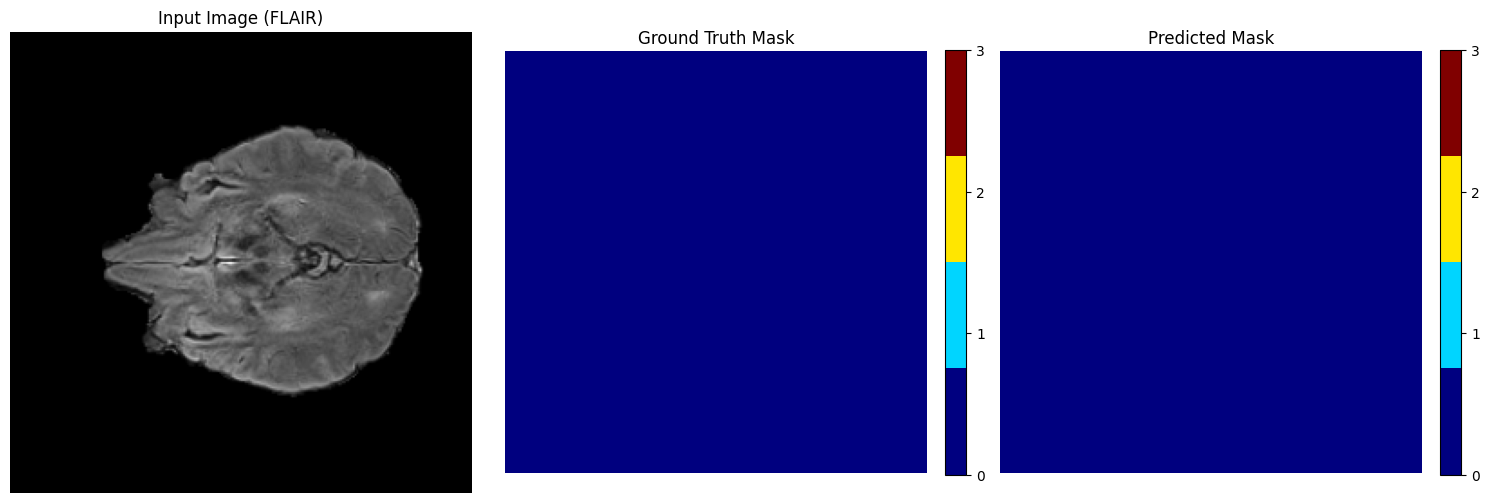

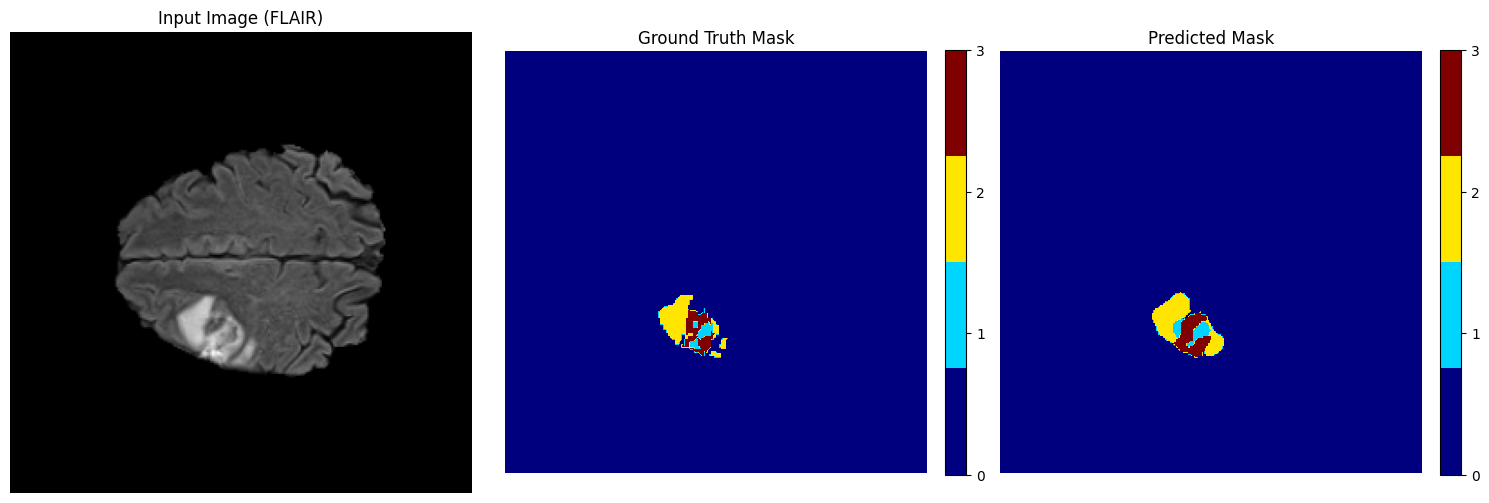

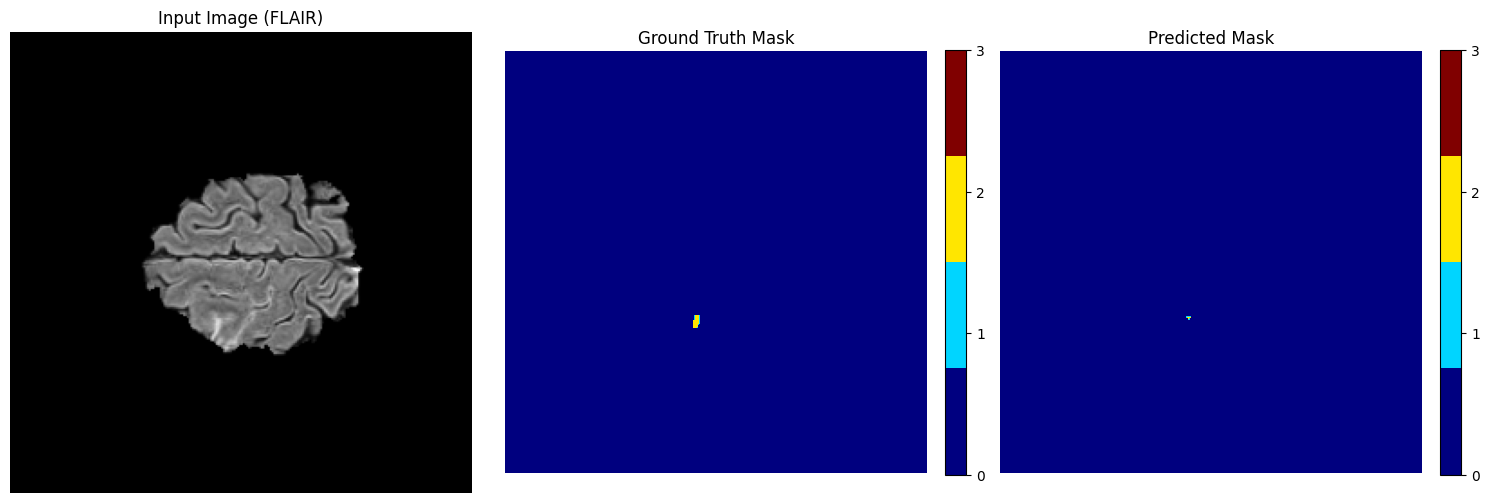

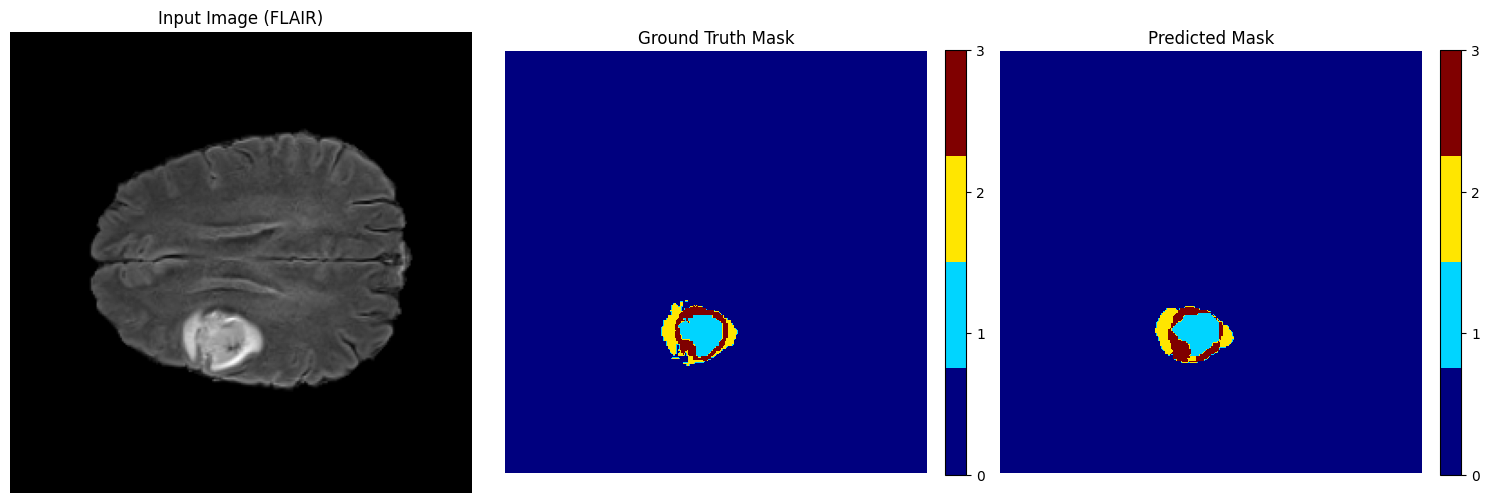

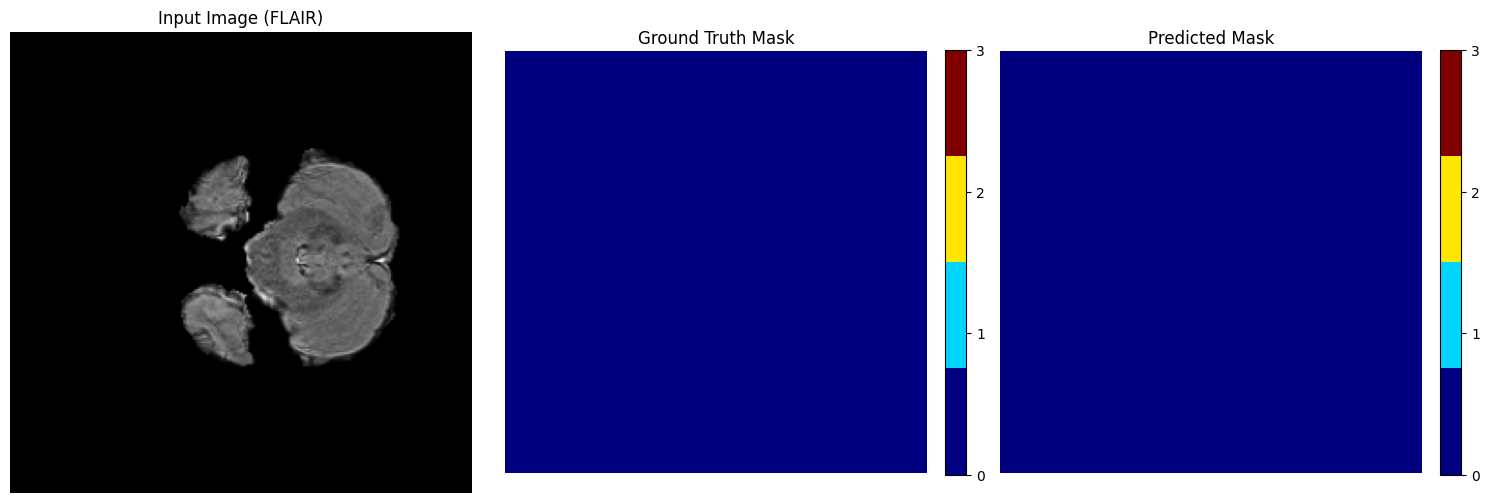

In [43]:
def visualize_predictions(model, data_generator, num_images=5, save_dir='images'):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Set the color map for segmentation classes
    cmap = plt.get_cmap('jet', len(SEGMENT_CLASSES))

    for X_batch, y_true_batch in data_generator:
        y_pred_batch = model.predict(X_batch)
        y_pred_argmax = np.argmax(y_pred_batch, axis=-1)
        y_true_argmax = np.argmax(y_true_batch, axis=-1)

        for i in range(num_images):
            plt.figure(figsize=(15, 5))

            # Original Image (FLAIR)
            plt.subplot(1, 3, 1)
            plt.imshow(X_batch[i, :, :, 0], cmap='gray')
            plt.title('Input Image (FLAIR)')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(y_true_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Ground Truth Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred_argmax[i], cmap=cmap, vmin=0, vmax=len(SEGMENT_CLASSES)-1)
            plt.title('Predicted Mask')
            plt.colorbar(ticks=range(len(SEGMENT_CLASSES)), fraction=0.046, pad=0.04)
            plt.axis('off')

            plt.tight_layout()
            # Save the figure
            plt.savefig(f"{save_dir}/sample_segmentation_{i+1}.png")
            plt.show()

        # Break after visualizing the desired number of images
        break

# Call the visualization function
visualize_predictions(model, validation_generator, num_images=5)

In [44]:
print(history.history.keys())

dict_keys(['accuracy', 'custom_mean_io_u_2', 'loss', 'val_accuracy', 'val_custom_mean_io_u_2', 'val_loss', 'learning_rate'])


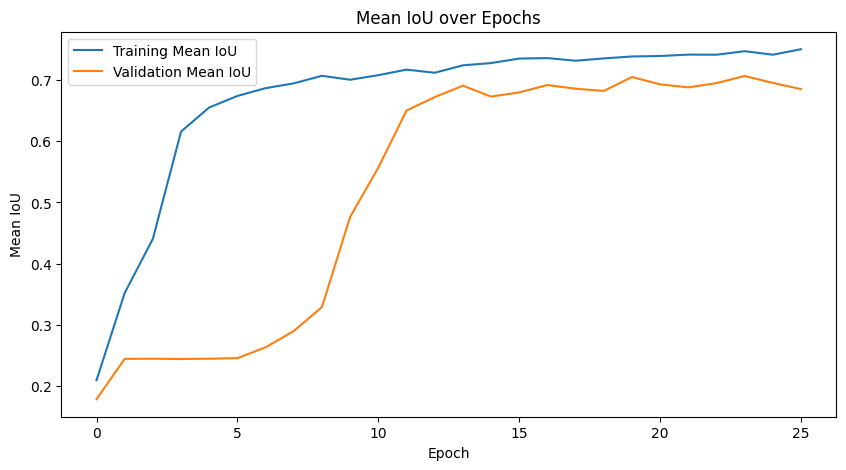

In [45]:
# Plot Training and Validation Mean IoU
plt.figure(figsize=(10, 5))
plt.plot(history.history['custom_mean_io_u_2'], label='Training Mean IoU')
plt.plot(history.history['val_custom_mean_io_u_2'], label='Validation Mean IoU')
plt.title('Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()
plt.savefig('images/mean_iou_plot.png')
plt.show()